In [14]:
import numpy as np
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt

In [6]:
T = 2000

Section 1. When Sharpe Ratio correlates with performance

In [7]:
def get_sharpe_ratio(returns):
    mean_returns = returns.mean()
    std_returns = returns.std()
    return mean_returns / std_returns

def get_geometric_return(returns):
    return np.exp(np.log(1 + returns).mean())

In [8]:
strat1_std = .1
strat1_mean = .05
strat2_std = .05
strat2_mean = .04
returns1 =  strat1_mean + strat1_std * np.random.randn(T)
returns2 = strat2_mean + strat2_std * np.random.randn(T)

In [9]:
print(returns1.mean())
print(returns1.std())
print(returns2.mean())
print(returns2.std())

0.04610111400244738
0.09870109162283681
0.040955793645238596
0.04857010063518924


In [10]:
# We want a strat with std 1, so we can use leverage of x in with returns2, where x = 2?
returns_strat_1 = 1 * returns1
returns_strat_2 = 2 * returns2
print(returns_strat_1.std())
print(returns_strat_2.std())

0.09870109162283681
0.09714020127037848


In [11]:
wealth_series_strat_1 = (1 + returns_strat_1).cumprod()
wealth_series_strat_2 = (1 + returns_strat_2).cumprod()

Text(0, 0.5, 'log_2(wealth)')

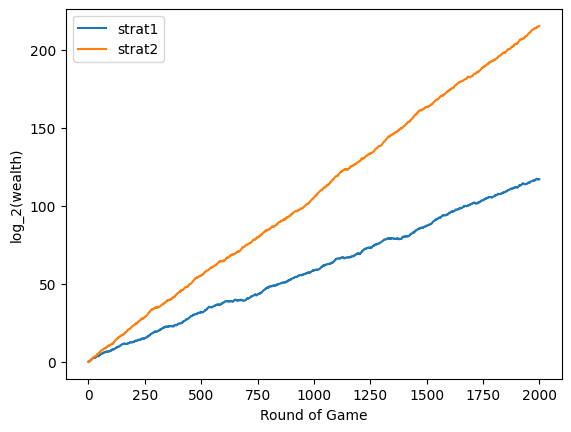

In [15]:
sns.lineplot(np.log2(wealth_series_strat_1), label = "strat1")
sns.lineplot(np.log2(wealth_series_strat_2), label = "strat2")
plt.xlabel("Round of Game")
plt.ylabel("log_2(wealth)")

In [9]:
print(get_sharpe_ratio(np.diff(wealth_series_strat_1)/wealth_series_strat_1[:-1]))
print(get_sharpe_ratio(np.diff(wealth_series_strat_2)/wealth_series_strat_2[:-1]))

0.48374576573724587
0.7932674156272488


In [20]:
# max r_1 w_1 + r_2 w_2 - 1/2 (s_11 w_1**2 + s22 w_2 **2)
# s.t. np.sqrt((s_11 w_1**2 + s22 w_2 **2)) = 1
def find_kelly_weights_std_constrained(returns, covariance, max_std_deviation):

    weights = cp.Variable(2)
    
    objective = cp.Maximize(cp.matmul(returns, weights) - .5 * cp.quad_form(weights, covariance))
    
    constraints = [cp.quad_form(weights, covariance) <= max_std_deviation**2]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

    return weights.value

In [21]:
kelly_weights = find_kelly_weights_std_constrained(np.array([strat1_mean, strat2_mean]), np.array([[strat1_std**2, 0],[0, strat2_std**2]]), .1)

In [28]:
print(kelly_weights)

[0.52999894 1.69599661]


In [29]:
kelly_returns = (kelly_weights.T @ np.vstack([returns1, returns2]))

In [33]:
print(kelly_returns.std())
print(get_sharpe_ratio(kelly_returns))
wealth_series_kelly = (1 + kelly_returns).cumprod()

0.09800307466116166
0.9580763567857579


Text(0, 0.5, 'log_2(wealth)')

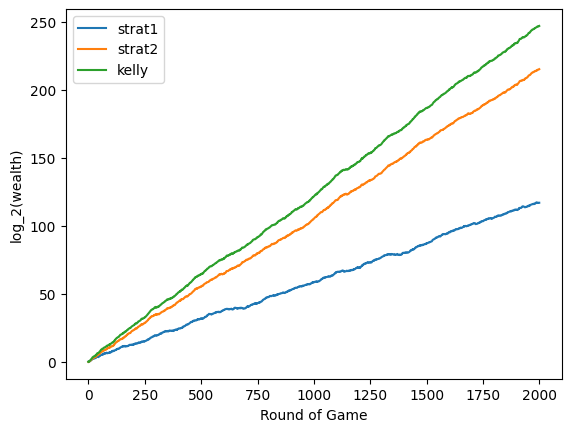

In [32]:
sns.lineplot(np.log2(wealth_series_strat_1), label = "strat1")
sns.lineplot(np.log2(wealth_series_strat_2), label = "strat2")
sns.lineplot(np.log2(wealth_series_kelly), label = "kelly")
plt.xlabel("Round of Game")
plt.ylabel("log_2(wealth)")

In [34]:
# so, this hints that when returns are normally distributed. a higher sharpe is better for maximizing long term wealth.
# but dont just pick the strategy with largest sharpe. It may be possible to get an even better sharpe by combining both strategies.
# Question: What if we maximize sharpe? Is this the same as mean variance optimization with lambda = 1? TODO: this would be a nice result!

End of Section 1

Section 2: Maximizing the Sharpe Ratio. Comparison with Kelly Portfolio
- Show trick to make convex
- Show maximizing does not imply fastest growth rate

In [40]:
def find_kelly_weights(returns, covariance):
    weights = cp.Variable(2)
    
    objective = cp.Maximize(cp.matmul(returns, weights) - .5 * cp.quad_form(weights, covariance))

    # constraints = [cp.sum(weights) == 1, weights >= 0]
    constraints = [cp.sum(weights) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

    return weights.value

def find_sharpe_weights(returns, covariance):
    weights = cp.Variable(2)
    
    objective = cp.Minimize(cp.quad_form(weights, covariance))

    constraints = [cp.matmul(weights, returns) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

    return weights.value / sum(weights.value)

In [41]:
print(find_kelly_weights(np.array([strat1_mean, strat2_mean]), np.array([[strat1_std**2, 0],[0, strat2_std**2]])))
print(find_sharpe_weights(np.array([strat1_mean, strat2_mean]), np.array([[strat1_std**2, 0],[0, strat2_std**2]])))

[9.99865589e-01 1.34410796e-04]
[0.23809524 0.76190476]


In [42]:
kelly_weights_no_leverage = find_kelly_weights(np.array([strat1_mean, strat2_mean]), np.array([[strat1_std**2, 0],[0, strat2_std**2]]))
sharpe_weights_no_leverage = find_sharpe_weights(np.array([strat1_mean, strat2_mean]), np.array([[strat1_std**2, 0],[0, strat2_std**2]]))

In [43]:
kelly_returns_no_leverage = (kelly_weights_no_leverage.T @ np.vstack([returns1, returns2]))
sharpe_returns_no_leverage = (sharpe_weights_no_leverage.T @ np.vstack([returns1, returns2]))

In [44]:
print(get_sharpe_ratio(kelly_returns_no_leverage))
print(get_sharpe_ratio(sharpe_returns_no_leverage))
# even with gaussian returns maximizing sharpe ratio != maximizing long run wealth!!!

0.4671335400808132
0.9580763565017542


In [45]:
print(get_geometric_return(kelly_returns_no_leverage))
print(get_geometric_return(sharpe_returns_no_leverage))

1.0414161343135713
1.0412479672906945


End of section 2. Maximizing Sharpe does not maximize wealth

Start of section 3. Sharpe Ratios when gambling on the outcome of a biased coin

In [50]:
np.random.seed(0)
returns = np.vstack([np.ones(T), np.random.choice([2, 0], p=[.6, .4], size=T)])
weights = np.array([.8, .2])

In [51]:
def compute_wealth_series(weights, returns):
    wealth = np.append([1], np.cumprod(weights.T @ returns))
    return wealth

In [52]:
wealth_kelly = compute_wealth_series(weights, returns)
wealth_half_kelly = compute_wealth_series(np.array([.9, .1]), returns)
wealth_double_kelly = compute_wealth_series(np.array([.6, .4]), returns)

Text(0, 0.5, 'log_2(wealth)')

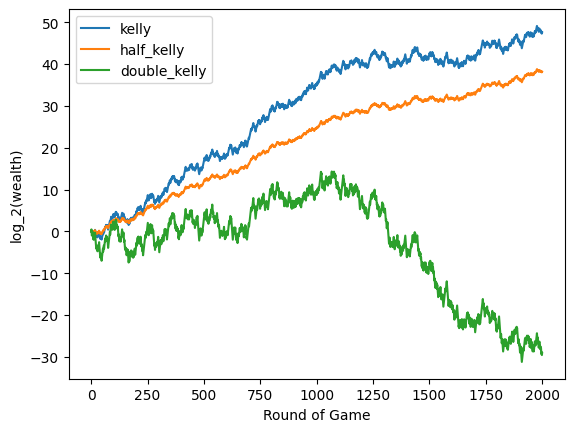

In [54]:
sns.lineplot(np.log2(wealth_kelly), label="kelly")
sns.lineplot(np.log2(wealth_half_kelly), label="half_kelly")
sns.lineplot(np.log2(wealth_double_kelly), label="double_kelly")
plt.xlabel("Round of Game")
plt.ylabel("log_2(wealth)")

In [58]:
def get_returns_from_wealth(wealth):
    return np.diff(wealth)/wealth[0:-1]

In [59]:
returns_kelly = get_returns_from_wealth(wealth_kelly)
returns_half_kelly = get_returns_from_wealth(wealth_half_kelly)
returns_double_kelly = get_returns_from_wealth(wealth_double_kelly)

In [60]:
# print(wealth_kelly[0:15])
print(returns_kelly[0:15])
print(returns_half_kelly[0:15])

[ 0.2 -0.2 -0.2  0.2  0.2 -0.2  0.2 -0.2 -0.2  0.2 -0.2  0.2  0.2 -0.2
  0.2]
[ 0.1 -0.1 -0.1  0.1  0.1 -0.1  0.1 -0.1 -0.1  0.1 -0.1  0.1  0.1 -0.1
  0.1]


In [61]:
print((1 + returns_kelly).mean())
print((1+returns_half_kelly).mean())
print((1+returns_double_kelly).mean())

1.0364
1.0182
1.0728


In [ ]:
# arithmetic returns in finance are a no no

In [43]:
print(get_geometric_return(returns_kelly))
print(get_geometric_return(returns_half_kelly))
print(get_geometric_return(returns_double_kelly))


1.019677875798585
1.014829713539239
0.9962046365573717


In [44]:
print(get_sharpe_ratio(returns_kelly))
print(get_sharpe_ratio(returns_half_kelly))
print(get_sharpe_ratio(returns_double_kelly))

0.20072545633891176
0.20072545633891178
0.20072545633891106


In [45]:
# Ha, sharpe is the same for all strategies even though our final wealth is dramatically different